# PyTorch ( 실제 파일 작업 dogs and cats)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

In [26]:
# GPU 사용 가능 여부 확인 -> GPU, CPU 선택

if torch.cuda.is_available():   # False
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


### 데이터 준비

In [27]:
# 데이터 다운로드

import kagglehub
# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\human\.cache\kagglehub\datasets\salader\dogs-vs-cats\versions\1


In [28]:
!copy C:\Users\human\.cache\kagglehub\datasets\salader\dogs-vs-cats\versions\1\dogs_vs_cats\* data_files\

C:\Users\human\.cache\kagglehub\datasets\salader\dogs-vs-cats\versions\1\dogs_vs_cats\* 

������ ������ ã�� �� �����ϴ�.



        0�� ������ ����Ǿ����ϴ�.


In [29]:
# 데이터 준비 1. (파일에서 읽어오면 이미지 크기가 제각각인데, 여기서 맞춰준다.)

transform =  transforms.Compose([transforms.RandomResizedCrop(256), transforms.ToTensor()])
# normalize 빼고 나머지 작업은 모두 ToTensor 전에 해라.

In [30]:
# 데이터 준비 2. (데이터셋 만들기 - 파일에서 읽어오기)

train_dataset = datasets.ImageFolder('data_files/dogs_vs_cats/train', transform=transform)
test_dataset = datasets.ImageFolder('data_files/dogs_vs_cats/test', transform=transform)

In [31]:
# 데이터 준비 3. (DataLoader)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=True)

In [32]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 256, 256]) torch.Size([32])


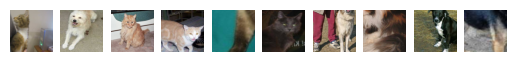

tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 1])

In [33]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].permute(1, 2, 0))
plt.show()
y[:10]

### 모델 만들기

In [60]:
# 모델 구조 설계

class dncCnn(nn.Module):
    def __init__(self):
        super(dncCnn, self).__init__()
        # Cnn이므로 Conv, Pool 필요. out_channels : 필터 개수, padding 수를 직접 지정해야한다. 1=same
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 256 > 128 > 64 > 32 > 16
        self.fc1 = nn.Linear(16*16*512, 32)   # flatten하는 것
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # conv 층 작업
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 16*16*512)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

In [61]:
# 학습 도구 구성
model = dncCnn().to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

dncCnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [69]:
# 훈련 함수 정의 (배치 10으로 하니 너무 많아서 300으로 조정)

def train(model, train_loader, optimizer):
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images).reshape(-1)
        loss = criterion(output, labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        if idx % 300 == 0:
            print(f'Batch : {idx}, Loss : {loss.item()}')

In [71]:
# 모델 평가 함수 정의

def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images).reshape(-1)
            loss = criterion(output, labels.to(torch.float32)).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item() # 비교하기
            correct_total += correct
    
    loss_total /= (len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)
    
    return loss_total, accuracy

In [ ]:
# 학습 실행

for epoch in range(10):
    train(model, train_loader, optimizer) 
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss : {loss}, Accuracy : {accuracy}")
    # 에폭마다 validation이 어떻게 개선되는지 볼 수 있게 함. (여기선 validation따로 안 만들어서 test로 함)

Batch : 0, Loss : 0.6971752643585205


In [23]:
# 최종적인 작업

evaluate(model, test_loader)
# 

(0.05625466647148132, 0.9839)